# EDA for Big Data Derby Competition

### Creating paths to diferent folders

In [1]:
import os
from pathlib import Path

# Get current work directory of file (Notebook dir)
NOTEBOOK_DIR=Path(os.path.abspath(os.getcwd()))
# Root path of repo
WORK_DIR=NOTEBOOK_DIR.parent.parent
# Path to Datasets
DATA_DIR=WORK_DIR / 'data'

# Noob printing to check if I did this shit right
print("Notebook dir: ", NOTEBOOK_DIR)
print("Repo dir: ", WORK_DIR)
print("Data dir: ", DATA_DIR)

Notebook dir:  r:\kaggle\big-data-derby-kaggle\notebooks\sainth
Repo dir:  r:\kaggle\big-data-derby-kaggle
Data dir:  r:\kaggle\big-data-derby-kaggle\data


### Loading csv into dataframes

In [41]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns

complete_data= pd.read_csv(DATA_DIR / 'nyra_2019_complete.csv', names=['track_id','race_date','race_number','program_number','trakus_index','latitude','longitude','distance_id','course_type','track_condition','run_up_distance','race_type','purse','post_time','weight_carried','jockey','odds','position_at_finish'])
complete_data['race_number'].value_counts()


C:\Users\santi\AppData\Local\Temp\ipykernel_19624\1277386293.py:6: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  complete_data= pd.read_csv(DATA_DIR / 'nyra_2019_complete.csv', names=['track_id','race_date','race_number','program_number','trakus_index','latitude','longitude','distance_id','course_type','track_condition','run_up_distance','race_type','purse','post_time','weight_carried','jockey','odds','position_at_finish'])


8     582413
6     575217
5     559884
7     554623
4     523846
2     515115
1     508808
9     492915
3     490256
10    283141
11     98804
12     31725
13     11683
Name: race_number, dtype: int64

In [39]:
race_result_df = complete_data.groupby(['race_date','race_number', 'program_number'])['track_id', 'race_type', 'jockey', 'track_condition','weight_carried','position_at_finish'].min()
race_result_df.head()

C:\Users\santi\AppData\Local\Temp\ipykernel_19624\2383185659.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  race_result_df = complete_data.groupby(['race_date','race_number', 'program_number'])['track_id', 'race_type', 'jockey', 'track_condition','weight_carried','position_at_finish'].min()


track_id race_type           jockey  \
race_date  race_number program_number                                       
2019-01-01 1           3                   AQU       AOC     Jose Lezcano   
                       4                   AQU       AOC     Jomar Garcia   
                       5                   AQU       AOC    Manuel Franco   
                       1                   AQU       AOC      Dylan Davis   
                       2                   AQU       AOC  Junior Alvarado   

                                      track_condition  weight_carried  \
race_date  race_number program_number                                   
2019-01-01 1           3                          MY              118   
                       4                          MY              123   
                       5                          MY              118   
                       1                          MY              123   
                       2                          MY              120   

                                       position_at_finish  
race_date  race_number program_number                      
2019-01-01 1           3                                4  
                       4                                5  
                       5                                1  
                       1                                2  
                       2                                3

## Load Race table df, and check race location distribution


In [ ]:
race_data = pd.read_csv(DATA_DIR / 'nyra_race_table.csv')

race_data['track_id'].value_counts().plot(kind='bar')

<AxesSubplot:>

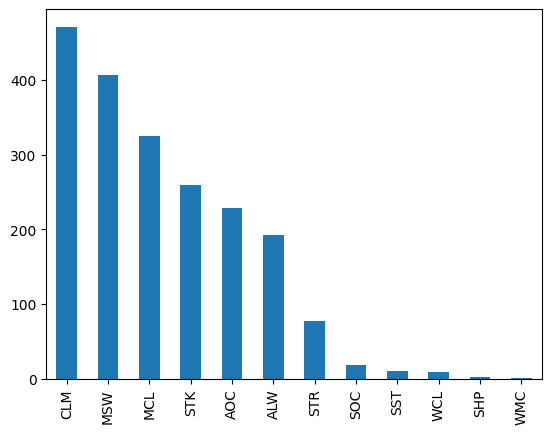

In [47]:
race_data['race_type'].value_counts().plot(kind='bar')